In [2]:
#https://www.youtube.com/watch?v=AfnBHL832Eg

#@title Установка нужных библиотек
!wget 'https://drive.google.com/uc?export=download&id=1oSFOP0j25OZAuhD8YXxyQXNTdr2lUdtn' -O requirements.txt
!pip install -r requirements.txt

--2021-11-12 13:12:48--  https://drive.google.com/uc?export=download&id=1oSFOP0j25OZAuhD8YXxyQXNTdr2lUdtn
Resolving drive.google.com (drive.google.com)... 142.250.141.100, 142.250.141.113, 142.250.141.102, ...
Connecting to drive.google.com (drive.google.com)|142.250.141.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0g-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/3ha0klg19umum4n22lehipf6g7vsm32m/1636722750000/14904333240138417226/*/1oSFOP0j25OZAuhD8YXxyQXNTdr2lUdtn?e=download [following]
--2021-11-12 13:12:49--  https://doc-0g-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/3ha0klg19umum4n22lehipf6g7vsm32m/1636722750000/14904333240138417226/*/1oSFOP0j25OZAuhD8YXxyQXNTdr2lUdtn?e=download
Resolving doc-0g-c0-docs.googleusercontent.com (doc-0g-c0-docs.googleusercontent.com)... 142.250.141.132, 2607:f8b0:4023:c0b::84
Connecting to doc-0g-c0-docs.googleusercontent.com (d

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

matplotlib.rcParams.update({'font.size': 14})

**Метрики** в машинном обучении нужны для того, чтобы оценивать качество работы модели, чтобы понимать, а насколько модель хорошо запомнила закономерности из обучающей выборки.  

Сегодня продолжаем рассматривать метрики для **задачи классификации**. Для такой задачи хочется, чтобы наши модели как можно чаще предсказывали верную метку класса объекта.

<img src='https://static.javatpoint.com/tutorial/machine-learning/images/classification-algorithm-in-machine-learning.png' width=600>


Уже познакомились с метрикой для классификации accuracy, если не знакомились, то обязательно сделайте это прямо сейчас. [Ссылка](https://drive.google.com/file/d/1RSIGFmdzTLYEPCcZUWcWvO9-UW23Bm-K/view?usp=sharing) на ноутбук и [ссылка](https://youtu.be/CCH-1gJo_z0) на видео на ютубе.

У метрики accuracy есть пара проблем:
- На выборках с дисбалансом классов метрика необъективна
- Невозможно давать вес для разных ошибок

Поэтому хочется ввести такую метрику, которая эти проблемы обходит стороной.

## Данные

Давайте вспомним, какие были ошибки с моделью кредитного скоринга.

0 классом помечаем клиентов, которые кредит не вернут, а 1 - которые вернут.
Выборка без дисбаланса классов, 5 объектов с классом 0, а 5 - с классом 1.



In [4]:
clients = [0, 0, 0, 0, 0, 
           1, 1, 1, 1, 1]
first_model_pred = [0, 0, 1, 1, 1,
                    1, 1, 1, 1, 1]
second_model_pred = [0, 0, 0, 0, 0,
                     1, 1, 0, 0, 0]


df = pd.DataFrame({
    'clients': clients,
    'first_model': first_model_pred,
    'second_model': second_model_pred
})

df

,clients,first_model,second_model
0,0,0,0
1,0,0,0
2,0,1,0
3,0,1,0
4,0,1,0
5,1,1,1
6,1,1,1
7,1,1,0
8,1,1,0
9,1,1,0


У нас получилось две модели с разными ошибками.

In [5]:
# Посмотрим правильность работы моделей
df['first_model_right'] = df['clients'] == df['first_model']
df['second_model_right'] = df['clients'] == df['second_model']

Давайте будем считать 1 класс **целевым**, то есть относительно первого класса будем считать метрики качества.  

В ситуации, когда модель предсказывает 1 класс, будем считать, что модель *сработала*, раз предсказала целевой класс.   
А в ситуации, когда модель предсказывает 0 класс, будем говорить, что модель *не сработала*, то есть *пропустила* объект, не увидела в нём целевой класс.

In [6]:
# Выведем ошибки первой модели

df[~df['first_model_right']][['clients', 'first_model']]

,clients,first_model
2,0,1
3,0,1
4,0,1


В этих ошибках первая модель одобрила кредит тем клиентам, которые его не погасят. На нулевой (нецелевой класс) предсказали первый (целевой), получается, *ложно сработали*.  
Данная ошибка называется *ложное срабатывание* или же **False Positive**.

In [7]:
# Выведем ошибки второй модели

df[~df['second_model_right']][['clients', 'second_model']]

,clients,second_model
7,1,0
8,1,0
9,1,0


Всё наоборот. В этих ошибках вторая модель не одобрила кредит тем клиентам, которые его могли оплатить. На объекты с первым (целевом классом) модель отвечает нулевым, то есть она *пропускает* объекты, не срабатывает на них.

Данная ошибка называется *ложный пропуск* или же **False Negative**. Модель не стала выдавать кредиты людям, которые были в силах всё выплатить.

Помимо ошибок есть ещё и хорошие срабатывания, когда модель на 1 класс отвечает первым классом:

In [8]:
# Посмотрим на ситуации, когда на 1 класс модель отвечает верно

df[(df['second_model_right']) & (df['clients'])][['clients', 'second_model']]

,clients,second_model
5,1,1
6,1,1


Такое верное поведение называется *истинное срабатывание* или же **True Positive**. Модель выдаёт кредит нужным людям.

И вторая хорошая ситуация, с верными пропусками, когда модель на 0 класс отвечает нулевым классом:

In [9]:
# Посмотрим на ситуации, когда на 0 класс модель отвечает верно

df[(df['second_model_right']) & ~(df['clients'])][['clients', 'second_model']]

,clients,second_model
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0




```
# This is formatted as code
```

Такое верное поведение называется *истинный пропуск* или же **True Negative**. Модель не выдаёт кредит плохим клиентам.

## Матрица ошибок (Confusion Matrix)

Оформим всё в матрицу:

|  <empty>   | $$y = 1$$ | $$y = 0$$ |
--- | --- | ---
| __$$a(x) = 1$$__  |  True Positive TP    |  False Positive  FP   |
| __$$a(x) = 0$$__ |   False Negative FN    |   True Negative TN   |


В матрице сверху отложены истинные ответы, слева - ответы алгоритма. Когда алгоритм относит объект к классу "1", говорим, что он *срабатывает*, а когда к "0", - *пропускает*. 
- Если алгоритм сработал (предсказал 1) и объект действительно относится к классу "1", получаем верное срабатывание/верный положительный ответ (**True Positive, TP**) - ВСЁ ВЕРНО
- Если алгоритм сработал (предсказал 1), а объект не относится к классу "1", это ложное срабатывание (**False Positive, FP**) - ОШИБКА
- Если алгоритм пропускает объект (предсказал 0), а его истинный класс "1", это ложный пропуск/ложный негативные ответ (**False Negative, FN**) - ОШИБКА
- Если алгоритм пропускает объект (предсказал 0), а истинный класс объекта "0", то это истинный пропуск (**True Negative, TN**) - ВСЁ ВЕРНО

Можем для нашей задачи для первой модели построить эту матрицу ошибок, она есть в `sklearn'e` в модуле `metrics` и называется `confusion_matrix`.



In [10]:
from sklearn.metrics import confusion_matrix

confusion_matrix(df['clients'], df['first_model'])

array([[2, 3],
       [0, 5]])

Но здесь легко запутаться, где истинные значения, где предсказания модели, где нулевой класс, а где первый, поэтому лучше визуализировать матрицу ошибок через heatmap.

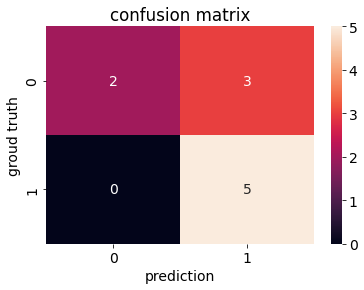

In [11]:
cm = confusion_matrix(df['clients'], df['first_model'])
sns.heatmap(cm, annot=True)

plt.title('confusion matrix')
plt.xlabel('prediction')
plt.ylabel('groud truth');

И теперь видим, что TN у нас 2 штуки, TP - 5 штук, а ошибок FP 3 штуки, когда на истинный нулевой класс модель ответила 1 классом.

На этих TP, TN, FP, FN основываются две хорошие метрики - Precision и Recall.

**Точность (precision)** представляет из себя *долю истинных срабатываний* от общего количества срабатываний. Она показывает, насколько можно доверять алгоритму классификации в случае срабатывания

$$precision(a, X) = \frac{TP}{TP+FP}.$$

**Полнота (recall)** считается как *доля объектов, истинно относящихся к классу "1"*, которые алгоритм отнес к этому классу

$$recall(a, X) = \frac{TP}{TP+FN},$$

здесь $TP+FN$ будут составлять весь список объектов класса "1".


Метрики могут изменяться от 0 до 1, где 0 - модель ниразу не попала правильно, все её предсказания ошибочные, а 1 - модель всё предсказала идеально.

Есть очень хорошая картинка, с помощью которой можно продемонстрировать, как подсчитываются метрики для классификации.  
- Левая прямоугольная затемненная область - это область целевых объектов, это наши клиенты с 1 классом
- Правая светлая прямоугольная область - область нерелевантных объектов с 0 классом, когда клиенты нам не возвращают кредиты
- То, что выделено в окружность - это объекты, на которых модель сработала, предсказала 1 класс
- А всё, что не вошло в окружность - это объекты, которые модель пропустила.

<img src='https://hsto.org/webt/so/oy/7k/sooy7k2lckgmsla2lgugjlisvh8.png' width=700>

И теперь пройдемся по каждой метрики в отдельности.

## Precision

**Точность (precision)** отвечает за *чистоту классификации*, рассчитывается, как истинные срабатывания, деленные на все срабатывания вообще.

$$precision(a, X) = \frac{TP}{TP+FP}$$

В идеале, когда знаменатель равен числителю, в этом случае метрика будет равна 1. В метрике precision минизируются ошибки *ложного срабатывания* (**False Positive**), хорошо, когда таких ошибок вообще нет, тогда классифицироваться как целевой класс будут только нужные нам объекты.

Посчитаем precision для первого класса для двух моделей.

### Первая модель

Сначала руками с помощью матрицы ошибок:

In [12]:
df[['clients', 'first_model']]

,clients,first_model
0,0,0
1,0,0
2,0,1
3,0,1
4,0,1
5,1,1
6,1,1
7,1,1
8,1,1
9,1,1


In [13]:
cm = confusion_matrix(df['clients'], df['first_model'])
tp = cm[1][1]
fp = cm[0][1]

precision_1_model = tp / (tp + fp)
precision_1_model

0.625

А теперь и с помощью функции `precision_score` из `sklearn`.

In [14]:
from sklearn.metrics import precision_score

precision_score(df['clients'], df['first_model'])

0.625

Метрика равна 0.625, мы верно классифицировали 5 объектов, а всего отнесли к первому классу 8 объектов, что и дало нам значение $\frac{5}{8} = 0.625$

### Вторая модель

Сначала руками с помощью матрицы ошибок:

In [15]:
df[['clients', 'second_model']]

,clients,second_model
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,1,1
6,1,1
7,1,0
8,1,0
9,1,0


In [16]:
cm = confusion_matrix(df['clients'], df['second_model'])
tp = cm[1][1]
fp = cm[0][1]

precision_2_model = tp / (tp + fp)
precision_2_model

1.0

А теперь и с помощью функции `precision_score` из `sklearn`.

In [17]:
from sklearn.metrics import precision_score

precision_score(df['clients'], df['second_model'])

1.0

Метрика равна 1, мы верно классифицировали два объектов из двух, которые модель отнесла к 1 классу, получается precision = $\frac{2}{2} = 1$.

Теперь две модели не кажутся такими одинаковыми, как были при подсчете метрики accuracy, по метрики precision выигрывает вторая модель, т.к. у неё нет *ложных срабатываний* **False Positive**, модель выдает кредиты только проверенным людям, поэтому и получилась очень *чистая* работа классификации.

## Recall

Посмотрим, как дела обстоят с другой метрикой.


**Полнота (recall)** отвечает за *количество классификаций*, рассчитывается, как истинные срабатывания, деленные на объекты целевого класса.


$$recall(a, X) = \frac{TP}{TP+FN}$$


В идеале, когда знаменатель равен числителю, в этом случае метрика будет равна 1. В метрике recall минизируются ошибки *ложного пропуска* (**False Negative**), хорошо, когда таких ошибок нет, тогда мы найдем все возможные объекты целевого класса и никого не пропустим.

Посчитаем recall для первого класса для двух моделей.

### Первая модель

Сначала руками с помощью матрицы ошибок:

In [18]:
df[['clients', 'first_model']]

,clients,first_model
0,0,0
1,0,0
2,0,1
3,0,1
4,0,1
5,1,1
6,1,1
7,1,1
8,1,1
9,1,1


In [19]:
cm = confusion_matrix(df['clients'], df['first_model'])
tp = cm[1][1]
fn = cm[1][0]

recall_1_model = tp / (tp + fn)
recall_1_model

1.0

А теперь и с помощью функции `recall_score` из `sklearn`.

In [20]:
from sklearn.metrics import recall_score

recall_score(df['clients'], df['first_model'])

1.0

Метрика равна 1, мы верно отнесли к 1 классу пять объектов из пяти, то есть нашли все объекты целевого класса, которые могли, по итогу и получили значение равное $\frac{5}{5} = 1$

### Вторая модель

Сначала руками с помощью матрицы ошибок:

In [21]:
df[['clients', 'second_model']]

,clients,second_model
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,1,1
6,1,1
7,1,0
8,1,0
9,1,0


In [22]:
cm = confusion_matrix(df['clients'], df['second_model'])
tp = cm[1][1]
fn = cm[1][0]

recall_2_model = tp / (tp + fn)
recall_2_model

0.4

А теперь и с помощью функции `recall_score` из `sklearn`.

In [23]:
from sklearn.metrics import recall_score

recall_score(df['clients'], df['second_model'])

0.4

Метрика равна 0.4, мы верно отнесли к целевому классу только два объекта из пяти возможных, то есть допустили 3 ошибки ложного пропуска false negative и получили метрику recall равную $\frac{2}{5} = 0.4$.

И снова модели не кажутся одинаковыми, их метрики recall сильно отличаются, теперь выигрышней смотрится первая модель, т.к. у неё нет *ложных пропусков* **False Negative**, модель выдала кредиты всем проверенным людям и никого не оставила без денег.

## Сравнение моделей

Сравним наши две модели по предсказанию 1 класса на 10 объектах:

|  <empty>   | first model | second model |
--- | --- | ---
| __precision__  |  0.625    |  1   |
| __recall__ |   1    |   0.4   |

У одной хороший recall, а у другой хороший precision, вот теперь можно смотреть на стратегию банка и принимать решение, что ему более важно:
- Если банку хочется **больше заработать**, то лучше выдавать кредиты *всем* людям, которые способны его вернуть, то есть ищем модель с максимальным *recall* - а это первая модель.
- Если банку хочется **меньше потерять**, то лучше выдавать кредиты *только* надежным людям, а значит ищем модель с лучшим *precision* - это вторая модель.


## Примеры задач

В разных задачах и на разных данных хочется не получать разные ошибки, сейчас посмотрим, в каких задачах максимизируется recall, а в каких precision.

### Классификация на АЭС

Представим, что мы обучили модель на классификацию людей при входе на критически важный объект - атомная электростанция.


<img src='https://static.wikia.nocookie.net/dark-netflix/images/9/9a/AKW_Winden_1987.jpg/revision/latest?cb=20201231042434' width=500>

- Если человек является сотрудником, то модель должна выдавать ему класс 1 и открывать двери на станцию
- А если человек не наш сотрудник, то модель должна его классифицировать, как класс 0 и не пускать на наш объект.

В этой ситуации, мы хотим сто процентов быть уверенными в том, что наша система пропускает только сотрудников этой АЭС, а не всех подряд.

*Подумайте, какую метрику здесь нужно максимизировать?*

Здесь хочется минимизировать *ложные срабатывания* **False Positive** - эти те случаи, где модель в чужом человеке с улицы увидела сотрудника АЭС. Поэтому в этой задаче классификации людей на *свой/чужой*, лучше максимизировать метрику *precision* - чистоту классификации.  

Есть и обратная сторона такой системы, каких-то своих настоящих сотрудников данная система может не признать, то есть допустить ошибку *ложного пропуска* **False Negative**, но такие ошибки для нас некритичны, гораздо критичней ошибки *ложного срабатывания* **False Positive**, в которых мы можем случайно запустить на станцию чужака.

### Классификация заболевания

А теперь пример из медицины, обучили модель на классификацию заболевания людей.

<img src='https://www.dolmanlaw.com/wp-content/uploads/2018/08/Florida-Medical-Malpractice-due-to-Misdiagnosis-and-Failure-to-Diagnose.jpg' width=500>


- Если у человека есть заболевание, то модель выдаст класс 1
- А если у человека нет заболевания, то модель предскажет класс 0

В ситуации, когда дело касается здоровья, лучше находить всех потенциально больных людей, чтобы как можно раньше начать лечение, а если модель случайно отнесла здорового человека в класс больного, то на следующих этапах обследований обнаружим, что человек здоровый.

*И снова подумайте, какую метрику здесь нужно максимизировать?*

Здесь хочется минимизировать *ложные пропуски* **False Negative** - эти те ситуации, где модель в больном человеке *не нашла* заболевание. Поэтому в этой задаче классификации людей на *больной/здоровый*, лучше максимизировать метрику *recall*, которая отвечает за количество классификаций.  

И снова другая сторона медали - каких-то здоровых людей данная модель может посчитать больными, то есть допустить ошибку *ложного срабатывания* **False Positive**, такие ошибки для нас неважно, ведь гораздо важнее ошибки *ложного пропуска* **False Negative**, в которых мы можем пропустить больного человека и не начать его лечить.

Иногда нам хочется снижать две ошибки одновременно, чтобы и **False Positive** не было, да и чтобы **False Negative** не случались, в этом случае мы можем пользоваться метрикой *F-score*, которая из себя представляет объединение Recall и Precision, про неё поговорим в этом [ноутбуке]() и [видео]().

## Summary

<table>

<tr>
<td>
Метрика
</td>

<td>
Формула
</td>

<td>
Диапазоны значений
</td>

<td>
Идеальное значение
</td>
</tr>

<tr>
<td>
Precision
</td>

<td>
$$precision = \frac{TP}{TP + FP}$$

</td>

<td>
[0, 1]
</td>

<td>
1
</td>
</tr>
<td>
Recall
</td>

<td>
$$recall = \frac{TP}{TP + FN}$$

</td>

<td>
[0, 1]
</td>

<td>
1
</td>
</tr>

<table>

В этом занятии посмотрели на метрики для задачи классификации, которые учитывают разные ошибки - Precision и Recall.

**Precision** хороша для
- Задач, где важна *чистота* классификации
- Где нам не нужны ошибки *False Positive*

**Recall** хорош для
- Задач, где важно *количество* классиифкаций
- Где нам не нужны ошибки *False Negative*



В целом, метрики используются для того, чтобы получить цифру оценки качества работы обученной модели, чтобы уже заранее знать, чего ожидать от модели, когда ей будем давать реальные данные, а также метрики можем использовать для обнаружения переобучения/недообучения. Про них разговор ведется в этом [ноутбуке](https://colab.research.google.com/drive/1MNpLMZGJCBwdNjY_PgJIKHtll6zvUEyU?usp=sharing) и в этом [видео](https://youtu.be/m7P7bnLxIc4).

Про остальные метрики для задачи классификации можно посмотреть здесь:
1. Accuracy. [ноутбук](https://colab.research.google.com/drive/1RSIGFmdzTLYEPCcZUWcWvO9-UW23Bm-K), [видео](https://youtu.be/CCH-1gJo_z0)
2. Precision, Recall. [ноутбук](https://colab.research.google.com/drive/179Jm_Y2F7SnVgBK-1wj9YpsjWXb71DBN?usp=sharing) и [видео](https://youtu.be/AfnBHL832Eg).
3. F-score. [ноутбук](https://colab.research.google.com/drive/1kcB1gNIqh3fJhz5XMtEtlwpfgnj-LO_c?usp=sharing), [видео](https://youtu.be/PeE3Fkt5W3Q) 

Муррр ♥